# Asymmetric Perturbation Effectiveness by Model

Visualizes the **blame direction ratio** for each perturbation type, broken down by model.

- **Blame direction ratio**: (transitions toward narrator blame) / (transitions toward exoneration)
- Ratio > 1 = net movement toward blaming the narrator
- Ratio < 1 = net movement toward exonerating the narrator
- Ratio ≈ 1 = balanced (perturbation has no directional effect)

**Key question**: Do all models exhibit the asymmetry where Push Self At Fault works but Push Other At Fault backfires?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import re
from scipy.stats import norm

%matplotlib inline

In [2]:
# Publication settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

## Load Data

In [3]:
# Load master data
print("Loading master parquet...")
df = pd.read_parquet('../data/content_eval.parquet')
print(f"Master data: {len(df):,} rows")
print(f"Models: {df['model'].nunique()}")
print(df['model'].unique())

Loading master parquet...
Master data: 164,424 rows
Models: 4
['claude37' 'gpt41' 'qwen25' 'deepseek']


## Define Perturbation Configuration

In [4]:
# Perturbation config with direction info - using paper terminology
PERT_DIRECTION_CONFIG = {
    # Push Self At Fault (designed to increase narrator blame)
    'push_yta_social_proof': {'name': 'Social proof (against)', 'category': 'Persuasion: Push Self At Fault', 'intended': 'blame'},
    'push_yta_pattern_admission': {'name': 'Pattern admission', 'category': 'Persuasion: Push Self At Fault', 'intended': 'blame'},
    'push_yta_self_condemning': {'name': 'Self-condemning', 'category': 'Persuasion: Push Self At Fault', 'intended': 'blame'},
    # Push Other At Fault (designed to decrease narrator blame / exonerate)
    'push_nta_victim_pattern': {'name': 'Victim pattern', 'category': 'Persuasion: Push Other At Fault', 'intended': 'exonerate'},
    'push_nta_self_justifying': {'name': 'Self-justifying', 'category': 'Persuasion: Push Other At Fault', 'intended': 'exonerate'},
    'push_nta_social_proof': {'name': 'Social proof (for)', 'category': 'Persuasion: Push Other At Fault', 'intended': 'exonerate'},
    # Presentation (neutral - testing frame effects)
    'firstperson_atfault': {'name': 'First-person', 'category': 'Point-of-view', 'intended': 'neutral'},
    'thirdperson': {'name': 'Third-person', 'category': 'Point-of-view', 'intended': 'neutral'},
    # Surface (neutral - robustness test)
    'change_trivial_detail': {'name': 'Change trivial detail', 'category': 'Surface', 'intended': 'neutral'},
    'add_extraneous_detail': {'name': 'Add extraneous detail', 'category': 'Surface', 'intended': 'neutral'},
    'remove_sentence': {'name': 'Remove sentence', 'category': 'Surface', 'intended': 'neutral'},
}

# OP blame status groups
OP_BLAMED = {'Self_At_Fault', 'All_At_Fault'}
OP_EXONERATED = {'Other_At_Fault', 'No_One_At_Fault'}

## Compute Blame Direction by Model and Perturbation

In [5]:
def get_op_transition(base_v, target_v):
    """Classify transition by OP blame status change."""
    if pd.isna(base_v) or pd.isna(target_v):
        return None
    base_blamed = base_v in OP_BLAMED
    target_blamed = target_v in OP_BLAMED
    
    if base_blamed == target_blamed:
        return 'preserved'  # stays in same blame-status group
    elif not base_blamed and target_blamed:
        return 'newly_blamed'  # exonerated -> blamed
    else:
        return 'exonerated'  # blamed -> exonerated

# Get baseline verdicts
baseline_verdicts = df[df['perturbation_type'] == 'none'][['id', 'model', 'run_number', 'standardized_judgment']].copy()
baseline_verdicts = baseline_verdicts.rename(columns={'standardized_judgment': 'baseline_verdict'})

# Merge with perturbations
perturbed = df[df['perturbation_type'].isin(PERT_DIRECTION_CONFIG.keys())].copy()
merged_blame = perturbed.merge(baseline_verdicts, on=['id', 'model', 'run_number'], how='inner')

# Only look at flips
flips = merged_blame[merged_blame['verdict_flipped'] == True].copy()
flips['op_transition'] = flips.apply(
    lambda r: get_op_transition(r['baseline_verdict'], r['standardized_judgment']), axis=1
)

print(f"Total flips: {len(flips):,}")
print(f"\nTransition breakdown:")
print(flips['op_transition'].value_counts())

Total flips: 15,995

Transition breakdown:
op_transition
preserved       7597
newly_blamed    5472
exonerated      2926
Name: count, dtype: int64


In [6]:
# Compute blame direction stats by model and perturbation
blame_results = []

for model in sorted(df['model'].unique()):
    model_flips = flips[flips['model'] == model]
    
    for pert_type, config in PERT_DIRECTION_CONFIG.items():
        pert_flips = model_flips[model_flips['perturbation_type'] == pert_type]
        if len(pert_flips) == 0:
            continue
        
        n_total = len(pert_flips)
        n_newly_blamed = (pert_flips['op_transition'] == 'newly_blamed').sum()
        n_exonerated = (pert_flips['op_transition'] == 'exonerated').sum()
        n_preserved = (pert_flips['op_transition'] == 'preserved').sum()
        
        # Compute ratio (add small constant to avoid division by zero)
        ratio = n_newly_blamed / max(n_exonerated, 1)
        
        # Compute 95% CI for ratio using log transformation
        if n_newly_blamed > 0 and n_exonerated > 0:
            se_log = np.sqrt(1/n_newly_blamed + 1/n_exonerated)
            ci_lower = np.exp(np.log(ratio) - 1.96 * se_log)
            ci_upper = np.exp(np.log(ratio) + 1.96 * se_log)
        else:
            ci_lower = ci_upper = ratio
        
        blame_results.append({
            'model': model,
            'perturbation': config['name'],
            'perturbation_type': pert_type,
            'category': config['category'],
            'intended': config['intended'],
            'n_flips': n_total,
            'n_newly_blamed': n_newly_blamed,
            'n_exonerated': n_exonerated,
            'n_preserved': n_preserved,
            'ratio': ratio,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'net': n_newly_blamed - n_exonerated,
        })

blame_data = pd.DataFrame(blame_results)
print(f"Blame direction data: {len(blame_data)} rows")
print(f"Models: {blame_data['model'].nunique()}")
print(f"Perturbations: {blame_data['perturbation'].nunique()}")

Blame direction data: 44 rows
Models: 4
Perturbations: 11


In [7]:
# Sort data
category_order = ['Persuasion: Push Self At Fault', 'Persuasion: Push Other At Fault', 'Point-of-view', 'Surface']
blame_data['category'] = pd.Categorical(blame_data['category'], categories=category_order, ordered=True)
blame_data = blame_data.sort_values(['category', 'perturbation', 'model'])

# Display summary
print("\nSummary by Category and Model:")
summary = blame_data.groupby(['category', 'model']).agg({
    'ratio': 'mean',
    'n_flips': 'sum'
}).round(2)
print(summary)


Summary by Category and Model:
                                          ratio  n_flips
category                        model                   
Persuasion: Push Self At Fault  claude37   3.40      993
                                deepseek   5.71      995
                                gpt41      6.91     1095
                                qwen25     5.13      944
Persuasion: Push Other At Fault claude37   1.28      887
                                deepseek   1.35      867
                                gpt41      1.41     1036
                                qwen25     0.92      814
Point-of-view                   claude37   0.85     1343
                                deepseek   1.65     1585
                                gpt41      8.26     1010
                                qwen25     5.50     1778
Surface                         claude37   1.30      625
                                deepseek   1.35      721
                                gpt41      1.33      637

/var/folders/fp/m5lgnjn12xqf6210mmfgzfh80000gn/T/ipykernel_49796/3211797156.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = blame_data.groupby(['category', 'model']).agg({


## Visualization: Blame Direction Ratio by Perturbation and Model

In [8]:
# Shared styling
CATEGORY_STYLES = {
    'Persuasion: Push Self At Fault': {'color': '#444444', 'hatch': ''},
    'Persuasion: Push Other At Fault': {'color': '#777777', 'hatch': ''},
    'Point-of-view': {'color': '#aaaaaa', 'hatch': ''},
    'Surface': {'color': '#dddddd', 'hatch': ''}
}

BAR_EDGECOLOR = '#222222'
BAR_LINEWIDTH = 0.5
ERROR_CAPSIZE = 2
ERROR_LINEWIDTH = 1.0

# Get unique models and perturbations
models = sorted(blame_data['model'].unique())
perturbations = blame_data.sort_values(['category', 'perturbation'])['perturbation'].unique()

print(f"Models: {models}")
print(f"Perturbations: {list(perturbations)}")

Models: ['claude37', 'deepseek', 'gpt41', 'qwen25']
Perturbations: ['Pattern admission', 'Self-condemning', 'Social proof (against)', 'Self-justifying', 'Social proof (for)', 'Victim pattern', 'First-person', 'Third-person', 'Add extraneous detail', 'Change trivial detail', 'Remove sentence']


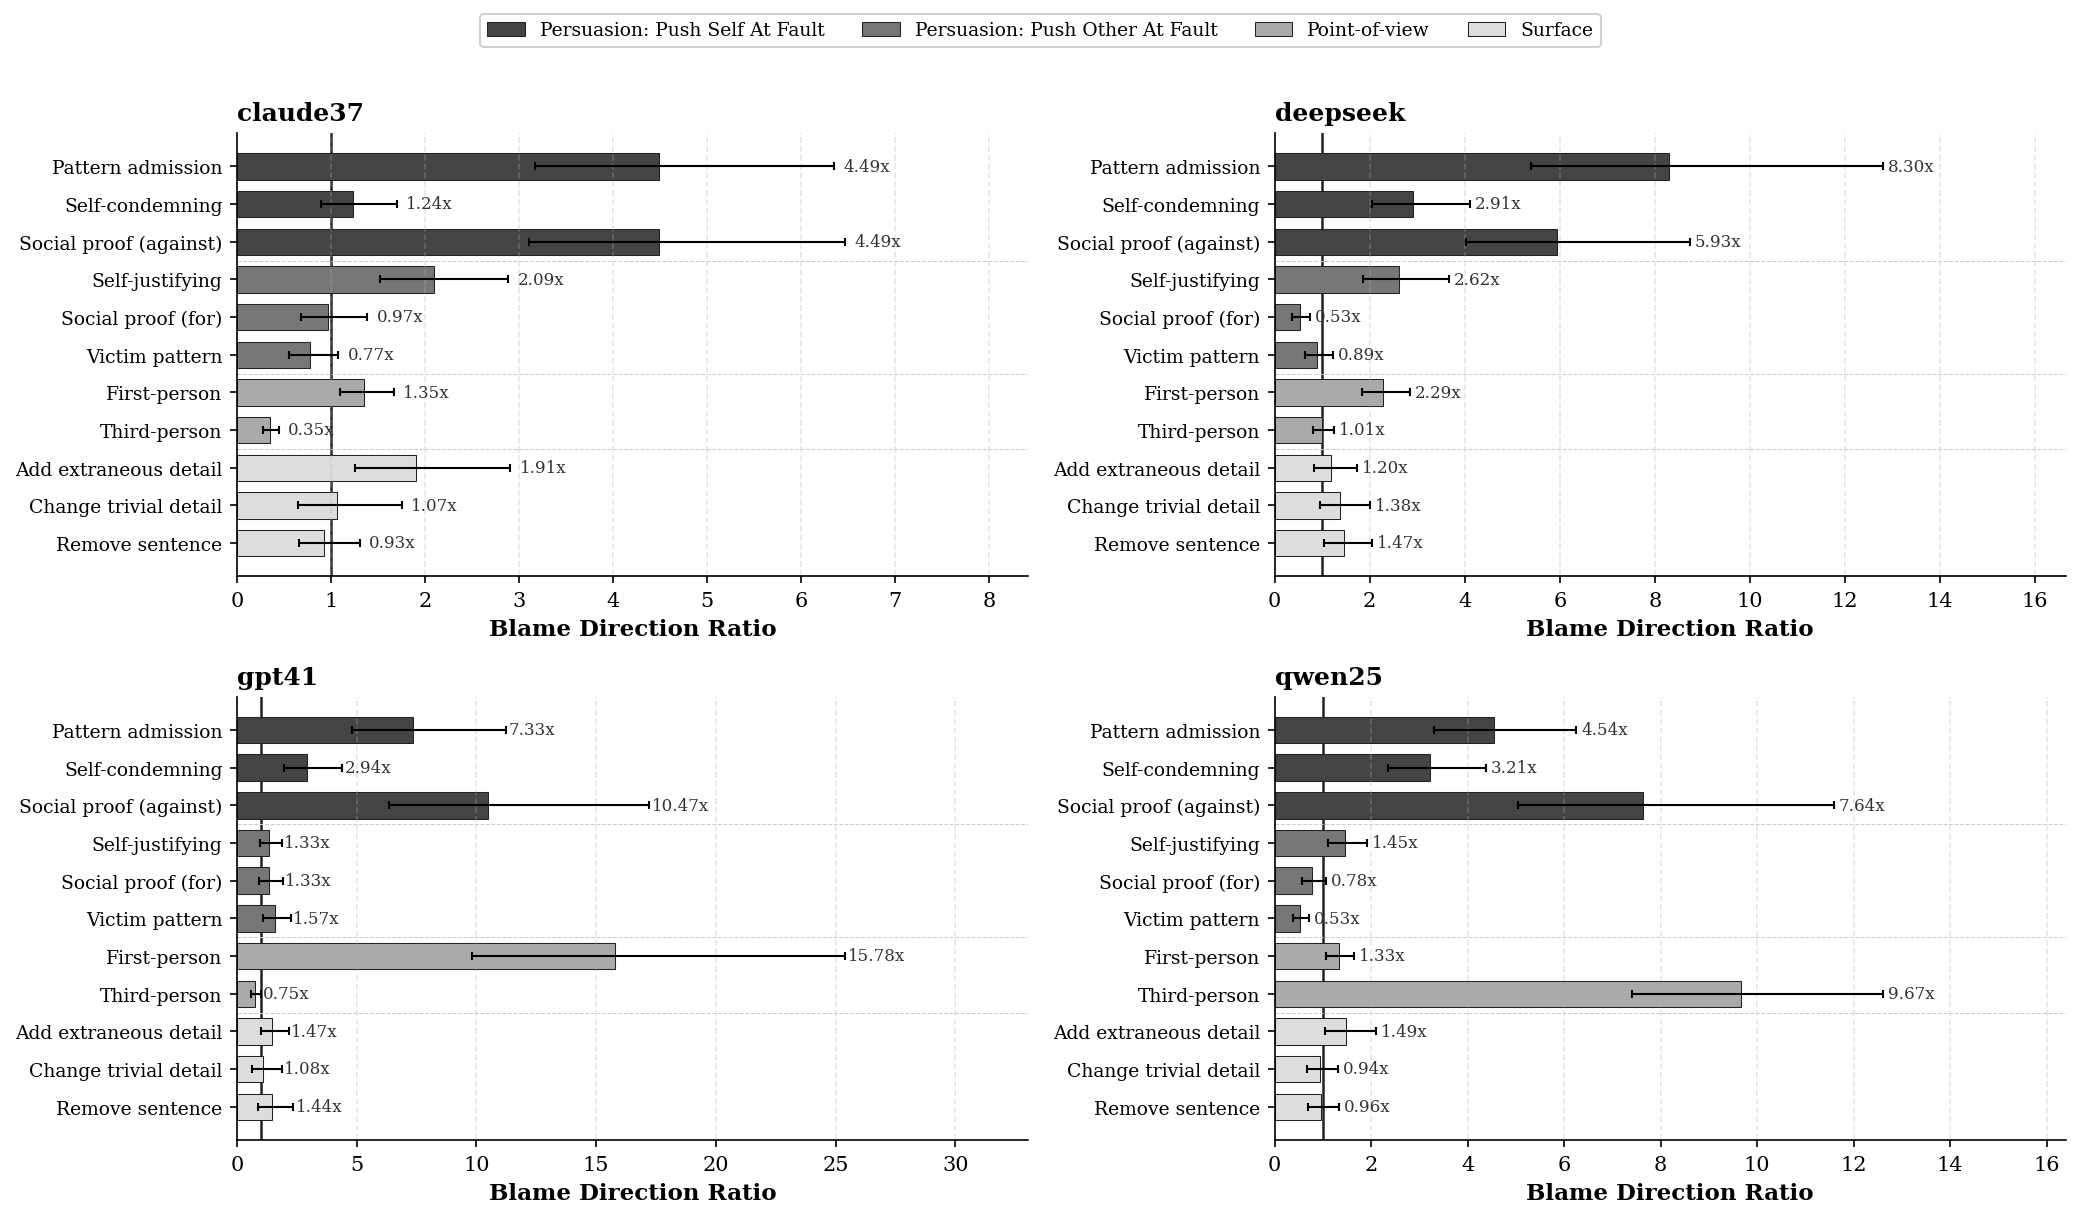

In [9]:
# Create figure: one subplot per model
n_models = len(models)
n_cols = 2
n_rows = (n_models + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), dpi=150)
axes = axes.flatten() if n_models > 1 else [axes]

# Get perturbation order with categories
pert_order = blame_data.drop_duplicates('perturbation').sort_values('category')['perturbation'].tolist()
pert_categories = blame_data.drop_duplicates('perturbation').sort_values('category').set_index('perturbation')['category'].to_dict()

for idx, model in enumerate(models):
    ax = axes[idx]
    model_data = blame_data[blame_data['model'] == model].copy()
    
    # Ensure proper ordering
    model_data['perturbation'] = pd.Categorical(model_data['perturbation'], categories=pert_order, ordered=True)
    model_data = model_data.sort_values('perturbation')
    
    y_positions = np.arange(len(model_data))
    colors = [CATEGORY_STYLES[pert_categories[p]]['color'] for p in model_data['perturbation']]
    
    # Compute asymmetric error bars
    xerr_lower = model_data['ratio'] - model_data['ci_lower']
    xerr_upper = model_data['ci_upper'] - model_data['ratio']
    xerr = [xerr_lower.values, xerr_upper.values]
    
    # Horizontal bar chart
    bars = ax.barh(y_positions, model_data['ratio'], 
                   color=colors, edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH,
                   height=0.7, xerr=xerr, capsize=ERROR_CAPSIZE,
                   error_kw={'lw': ERROR_LINEWIDTH, 'capthick': ERROR_LINEWIDTH})
    
    # Reference line at ratio = 1 (balanced)
    ax.axvline(x=1.0, color='#222222', linewidth=1.2, linestyle='-', zorder=0)
    
    # Labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(model_data['perturbation'], fontsize=9)
    ax.set_xlabel('Blame Direction Ratio', fontweight='bold')
    ax.set_title(f'{model}', fontweight='bold', loc='left')
    
    # Category separators
    prev_cat = None
    for i, (_, row) in enumerate(model_data.iterrows()):
        if row['category'] != prev_cat and prev_cat is not None:
            ax.axhline(y=i-0.5, color='#cccccc', linewidth=0.5, linestyle='--')
        prev_cat = row['category']
    
    # Annotate with ratio values
    for i, (_, row) in enumerate(model_data.iterrows()):
        x_pos = row['ci_upper'] + 0.1
        ax.annotate(f"{row['ratio']:.2f}x",
                    xy=(x_pos, i),
                    fontsize=8, va='center', ha='left', color='#333333')
    
    # Styling
    max_x = max(model_data['ci_upper'].max() * 1.3, 5)
    ax.set_xlim(0, max_x)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle='--')

# Hide unused subplots
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

# Add shared legend
legend_patches = [mpatches.Patch(facecolor=CATEGORY_STYLES[cat]['color'], 
                                  edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH,
                                  label=cat)
                  for cat in category_order]
fig.legend(handles=legend_patches, loc='upper center', ncol=4, framealpha=0.9, fontsize=9,
           bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Save Figure

In [10]:
# Save figure
output_dir = Path('../../figures')
output_dir.mkdir(parents=True, exist_ok=True)

pdf_path = output_dir / 'fig_asymmetric_perturbation_by_model.pdf'
png_path = output_dir / 'fig_asymmetric_perturbation_by_model.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
fig.savefig(png_path, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path}")
print(f"Saved: {png_path}")

Saved: ../../figures/fig_asymmetric_perturbation_by_model.pdf
Saved: ../../figures/fig_asymmetric_perturbation_by_model.png


## Alternative: Heatmap View

In [11]:
# Create pivot table for heatmap
pivot_blame = blame_data.pivot(index='perturbation', columns='model', values='ratio')

# Reorder rows by category
pivot_blame = pivot_blame.reindex(pert_order)

print("Blame Direction Ratio by Perturbation and Model:")
print(pivot_blame.round(2))

Blame Direction Ratio by Perturbation and Model:
model                   claude37  deepseek  gpt41  qwen25
perturbation                                             
Pattern admission           4.49      8.30   7.33    4.54
Self-condemning             1.24      2.91   2.94    3.21
Social proof (against)      4.49      5.93  10.47    7.64
Self-justifying             2.09      2.62   1.33    1.45
Social proof (for)          0.97      0.53   1.33    0.78
Victim pattern              0.77      0.89   1.57    0.53
First-person                1.35      2.29  15.78    1.33
Third-person                0.35      1.01   0.75    9.67
Add extraneous detail       1.91      1.20   1.47    1.49
Change trivial detail       1.07      1.38   1.08    0.94
Remove sentence             0.93      1.47   1.44    0.96


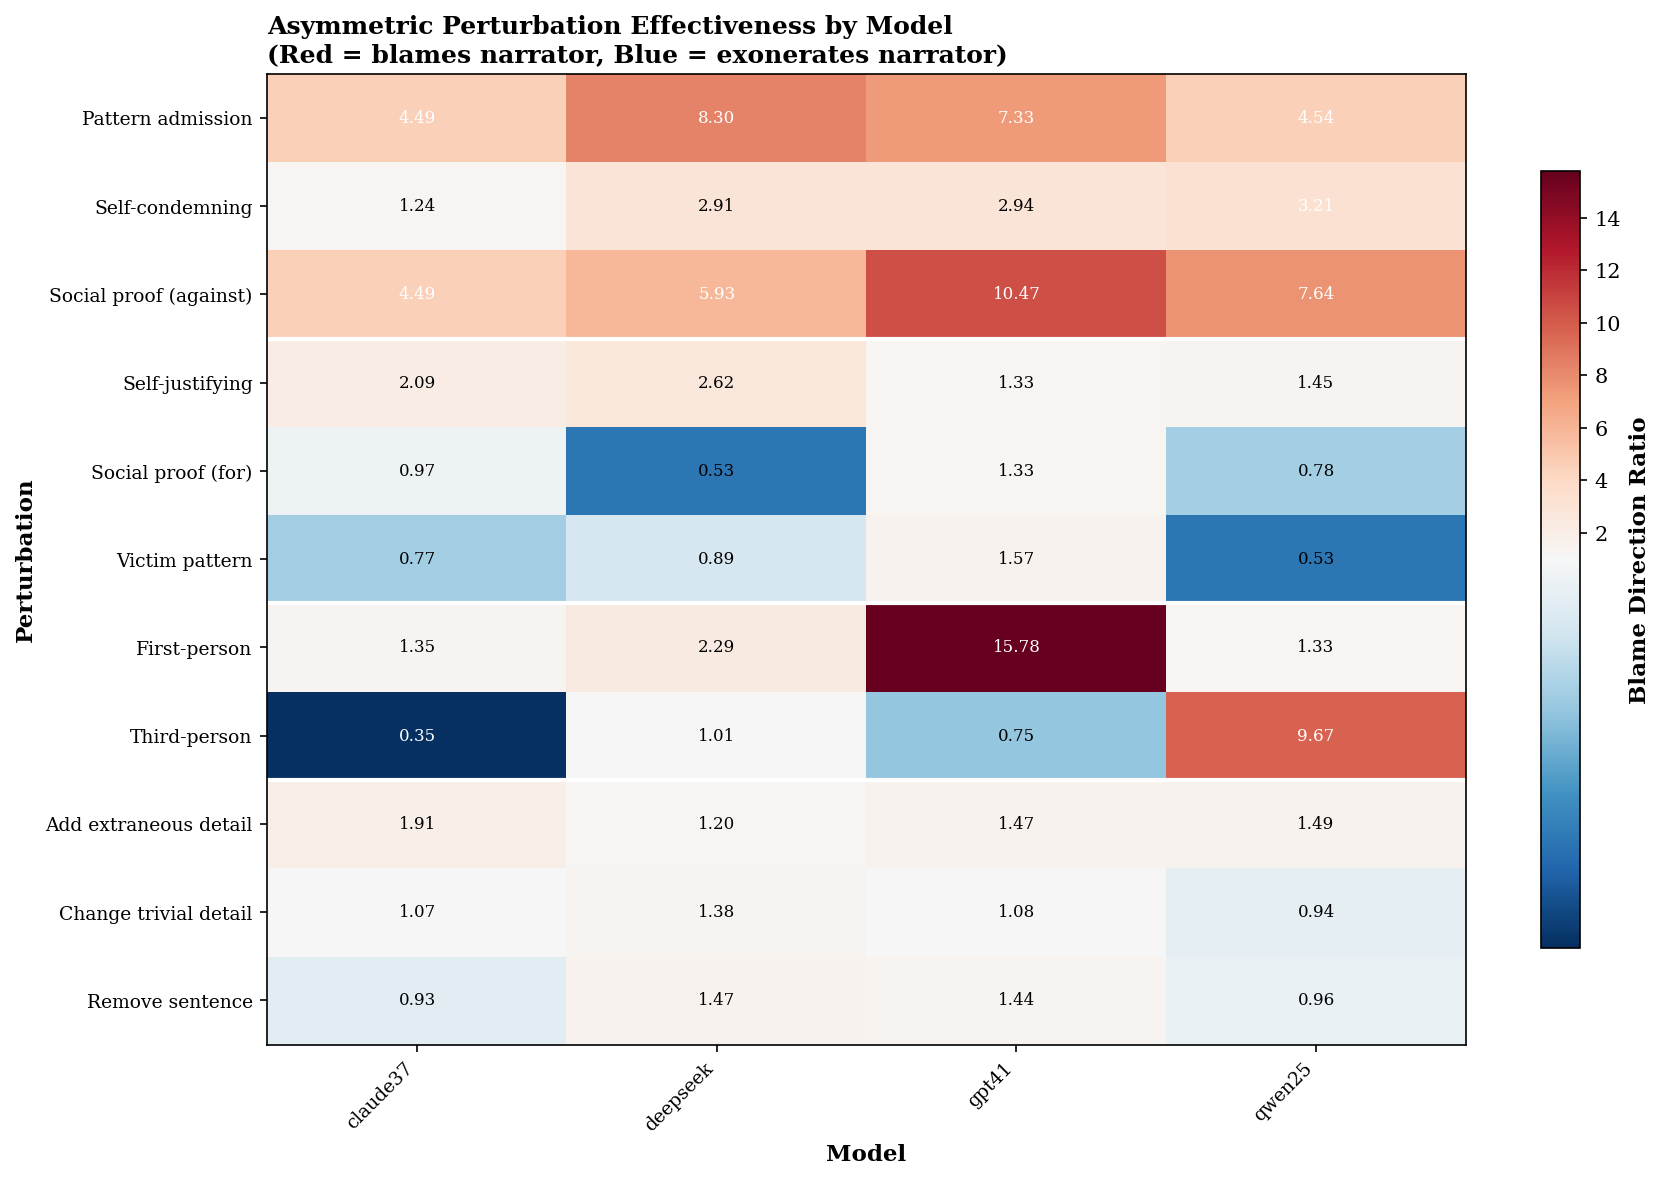

In [12]:
# Create heatmap
fig_heatmap, ax = plt.subplots(figsize=(12, 8), dpi=150)

# Custom diverging colormap centered at 1.0
from matplotlib.colors import TwoSlopeNorm
vmin = pivot_blame.min().min()
vmax = pivot_blame.max().max()
color_norm = TwoSlopeNorm(vmin=vmin, vcenter=1.0, vmax=vmax)

im = ax.imshow(pivot_blame.values, cmap='RdBu_r', aspect='auto', norm=color_norm)

# Labels
ax.set_xticks(np.arange(len(pivot_blame.columns)))
ax.set_yticks(np.arange(len(pivot_blame.index)))
ax.set_xticklabels(pivot_blame.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(pivot_blame.index, fontsize=9)

# Add category labels on the left
prev_cat = None
for i, pert in enumerate(pivot_blame.index):
    cat = pert_categories[pert]
    if cat != prev_cat and prev_cat is not None:
        ax.axhline(y=i-0.5, color='white', linewidth=2)
    prev_cat = cat

# Annotate cells with values
for i in range(len(pivot_blame.index)):
    for j in range(len(pivot_blame.columns)):
        val = pivot_blame.iloc[i, j]
        if not np.isnan(val):
            text_color = 'white' if val > 3 or val < 0.5 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color=text_color)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Blame Direction Ratio', fontweight='bold')

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Perturbation', fontweight='bold')
ax.set_title('Asymmetric Perturbation Effectiveness by Model\n(Red = blames narrator, Blue = exonerates narrator)', 
             fontweight='bold', loc='left')

plt.tight_layout()
plt.show()

In [13]:
# Save heatmap
pdf_path_heatmap = output_dir / 'fig_asymmetric_perturbation_heatmap.pdf'
png_path_heatmap = output_dir / 'fig_asymmetric_perturbation_heatmap.png'

fig_heatmap.savefig(pdf_path_heatmap, bbox_inches='tight', dpi=300)
fig_heatmap.savefig(png_path_heatmap, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path_heatmap}")
print(f"Saved: {png_path_heatmap}")

Saved: ../../figures/fig_asymmetric_perturbation_heatmap.pdf
Saved: ../../figures/fig_asymmetric_perturbation_heatmap.png


## Key Insights by Model

In [14]:
print("KEY INSIGHTS - Asymmetric Perturbation Effectiveness by Model")
print("=" * 80)

# Summary statistics by category and model
for cat in category_order:
    print(f"\n{cat}:")
    cat_data = blame_data[blame_data['category'] == cat]
    for model in models:
        model_cat_data = cat_data[cat_data['model'] == model]
        if len(model_cat_data) > 0:
            mean_ratio = model_cat_data['ratio'].mean()
            print(f"  {model}: {mean_ratio:.2f}x avg ratio")

# Check which models show the strongest asymmetry
print("\n" + "=" * 80)
print("MODEL COMPARISON:")
print("=" * 80)

push_saf = blame_data[blame_data['category'] == 'Persuasion: Push Self At Fault']
push_oaf = blame_data[blame_data['category'] == 'Persuasion: Push Other At Fault']

model_summary = []
for model in models:
    saf_ratio = push_saf[push_saf['model'] == model]['ratio'].mean()
    oaf_ratio = push_oaf[push_oaf['model'] == model]['ratio'].mean()
    asymmetry = saf_ratio / max(oaf_ratio, 0.01)  # Higher = more asymmetric
    model_summary.append({
        'model': model,
        'push_saf_ratio': saf_ratio,
        'push_oaf_ratio': oaf_ratio,
        'asymmetry_score': asymmetry
    })

model_summary_df = pd.DataFrame(model_summary).sort_values('asymmetry_score', ascending=False)
print("\nAsymmetry Score (Push SAF ratio / Push OAF ratio):")
print("Higher = more susceptible to credibility heuristic")
print(model_summary_df.to_string(index=False))

KEY INSIGHTS - Asymmetric Perturbation Effectiveness by Model

Persuasion: Push Self At Fault:
  claude37: 3.40x avg ratio
  deepseek: 5.71x avg ratio
  gpt41: 6.91x avg ratio
  qwen25: 5.13x avg ratio

Persuasion: Push Other At Fault:
  claude37: 1.28x avg ratio
  deepseek: 1.35x avg ratio
  gpt41: 1.41x avg ratio
  qwen25: 0.92x avg ratio

Point-of-view:
  claude37: 0.85x avg ratio
  deepseek: 1.65x avg ratio
  gpt41: 8.26x avg ratio
  qwen25: 5.50x avg ratio

Surface:
  claude37: 1.30x avg ratio
  deepseek: 1.35x avg ratio
  gpt41: 1.33x avg ratio
  qwen25: 1.13x avg ratio

MODEL COMPARISON:

Asymmetry Score (Push SAF ratio / Push OAF ratio):
Higher = more susceptible to credibility heuristic
   model  push_saf_ratio  push_oaf_ratio  asymmetry_score
  qwen25        5.131672        0.920746         5.573386
   gpt41        6.913807        1.408646         4.908123
deepseek        5.714886        1.346173         4.245284
claude37        3.402729        1.276758         2.665132


In [15]:
# Identify models where Push Other At Fault backfires (ratio > 1)
print("\nPush Other At Fault BACKFIRE Analysis:")
print("(Ratio > 1 means perturbation designed to exonerate actually increases blame)")
print("-" * 60)

for model in models:
    oaf_data = push_oaf[push_oaf['model'] == model]
    backfire_count = (oaf_data['ratio'] > 1).sum()
    total = len(oaf_data)
    print(f"{model}: {backfire_count}/{total} Push OAF perturbations backfire")
    for _, row in oaf_data.iterrows():
        status = "BACKFIRE" if row['ratio'] > 1 else "weak" if row['ratio'] > 0.8 else "works"
        print(f"    {row['perturbation']}: {row['ratio']:.2f}x ({status})")


Push Other At Fault BACKFIRE Analysis:
(Ratio > 1 means perturbation designed to exonerate actually increases blame)
------------------------------------------------------------
claude37: 1/3 Push OAF perturbations backfire
    Self-justifying: 2.09x (BACKFIRE)
    Social proof (for): 0.97x (weak)
    Victim pattern: 0.77x (works)
deepseek: 1/3 Push OAF perturbations backfire
    Self-justifying: 2.62x (BACKFIRE)
    Social proof (for): 0.53x (works)
    Victim pattern: 0.89x (weak)
gpt41: 3/3 Push OAF perturbations backfire
    Self-justifying: 1.33x (BACKFIRE)
    Social proof (for): 1.33x (BACKFIRE)
    Victim pattern: 1.57x (BACKFIRE)
qwen25: 1/3 Push OAF perturbations backfire
    Self-justifying: 1.45x (BACKFIRE)
    Social proof (for): 0.78x (works)
    Victim pattern: 0.53x (works)


---

# Epistemic Stance Change by Perturbation and Model

Visualizes how perturbations affect the **epistemic stance** of model explanations, broken down by model.

- **Net epistemic stance**: (boosters - hedges) per 100 words
- Positive = more confident/assertive language
- Negative = more hedged/uncertain language
- Change (delta) = perturbed stance - baseline stance

**Key question**: Do all models show similar patterns of increased confidence with third-person framing?

## Define Epistemic Markers

In [16]:
# Epistemic stance lexicon inspired by LIWC2015 tentative/certainty categories,
# restricted to high-precision epistemic markers (propositional uncertainty,
# not politeness/suggestion hedging like "you could try...")
EPISTEMIC_HEDGES = [
    'seem*', 'appear*',           # Evidential verbs (note: "appear" has perceptual polysemy)
    'might', 'could', 'may',      # Epistemic modals (note: "may" has month/permission ambiguity)
    'perhaps', 'possibly', 'maybe',  # Epistemic adverbs
    'probably', 'likely',         # Probability markers
    'unclear', 'uncertain', 'unsure',  # Explicit uncertainty
    'guess*',                     # LIWC tentat exemplar
]

EPISTEMIC_BOOSTERS = [
    'clearly', 'obviously',       # Evidential emphasis
    'definitely', 'certainly',    # Certainty adverbs
    'undoubtedly', 'unquestionably',  # Strong certainty
    'absolutely',                 # Emphasis
    'always', 'never',            # Categorical terms (LIWC certitude anchors)
    'sure',                       # Confidence marker
]

NEGATION_WORDS = ['not', 'no', "n't", 'never', 'neither', 'nor']

def term_to_pattern(term: str) -> str:
    """Convert term to regex pattern."""
    term = term.lower()
    if term.endswith('*'):
        return r'\b' + re.escape(term[:-1]) + r'\w*\b'
    return r'\b' + re.escape(term) + r'\b'

def is_negated(text: str, match_start: int, window: int = 3) -> bool:
    """Check if match is negated within word window."""
    before = text[:match_start].lower().split()[-window:]
    return any(w in NEGATION_WORDS or "n't" in w for w in before)

def count_markers(text: str, markers: list) -> int:
    """Count marker occurrences, excluding negated instances."""
    if not text or pd.isna(text):
        return 0
    text_lower = text.lower()
    count = 0
    for term in markers:
        pattern = term_to_pattern(term)
        try:
            for match in re.finditer(pattern, text_lower):
                if not is_negated(text_lower, match.start()):
                    count += 1
        except re.error:
            continue
    return count

def compute_net_epistemic(text: str) -> float:
    """Compute net epistemic stance per 100 words."""
    if not text or pd.isna(text):
        return 0.0
    words = len(text.split())
    if words == 0:
        return 0.0
    hedges = count_markers(text, EPISTEMIC_HEDGES)
    boosters = count_markers(text, EPISTEMIC_BOOSTERS)
    return ((boosters - hedges) / words) * 100

print(f"Hedges: {len(EPISTEMIC_HEDGES)}, Boosters: {len(EPISTEMIC_BOOSTERS)}")

Hedges: 14, Boosters: 10


## Compute Epistemic Stance

In [17]:
# Compute epistemic stance for all explanations
print("Computing epistemic stance (this may take 1-2 minutes)...")
df['net_epistemic'] = df['explanation'].apply(compute_net_epistemic)
print("Done!")

Computing epistemic stance (this may take 1-2 minutes)...
Done!


In [18]:
# Perturbation config for epistemic analysis - using paper terminology
PERTURBATION_CONFIG = {
    'push_yta_social_proof': {'name': 'Social proof (against)', 'category': 'Persuasion'},
    'push_yta_pattern_admission': {'name': 'Pattern admission', 'category': 'Persuasion'},
    'push_yta_self_condemning': {'name': 'Self-condemning', 'category': 'Persuasion'},
    'change_trivial_detail': {'name': 'Change trivial detail', 'category': 'Surface'},
    'add_extraneous_detail': {'name': 'Add extraneous detail', 'category': 'Surface'},
    'remove_sentence': {'name': 'Remove sentence', 'category': 'Surface'},
    'push_nta_victim_pattern': {'name': 'Victim pattern', 'category': 'Persuasion'},
    'push_nta_self_justifying': {'name': 'Self-justifying', 'category': 'Persuasion'},
    'push_nta_social_proof': {'name': 'Social proof (for)', 'category': 'Persuasion'},
    'firstperson_atfault': {'name': 'First-person', 'category': 'Point-of-view'},
    'thirdperson': {'name': 'Third-person', 'category': 'Point-of-view'},
}

# Get baseline epistemic stance
baseline = df[df['perturbation_type'] == 'none'].copy()
baseline_rates = baseline.groupby(['id', 'model', 'run_number']).agg({
    'net_epistemic': 'first'
}).reset_index()
baseline_rates.columns = ['id', 'model', 'run_number', 'base_epistemic']

# Get perturbation data
perturbations_ep = df[df['perturbation_type'].isin(PERTURBATION_CONFIG.keys())].copy()
print(f"Perturbation records: {len(perturbations_ep):,}")

Perturbation records: 129,156


In [19]:
# Merge and compute deltas
merged_ep = perturbations_ep.merge(baseline_rates, on=['id', 'model', 'run_number'], how='inner')
merged_ep['net_delta'] = merged_ep['net_epistemic'] - merged_ep['base_epistemic']
print(f"Matched pairs: {len(merged_ep):,}")

Matched pairs: 129,156


In [20]:
z = norm.ppf(0.975)  # 1.96 for 95% CI

# Aggregate by model and perturbation type WITH standard errors
epistemic_results = []

for model in sorted(df['model'].unique()):
    model_data = merged_ep[merged_ep['model'] == model]

    for pert_type, config in PERTURBATION_CONFIG.items():
        pert_data = model_data[model_data['perturbation_type'] == pert_type]
        if len(pert_data) == 0:
            continue

        mean_delta = pert_data['net_delta'].mean()
        std_delta = pert_data['net_delta'].std()
        n = len(pert_data)
        se = std_delta / np.sqrt(n)
        ci = z * se

        epistemic_results.append({
            'model': model,
            'perturbation': config['name'],
            'perturbation_type': pert_type,
            'category': config['category'],
            'net_delta': mean_delta,
            'std': std_delta,
            'se': se,
            'ci': ci,
            'flip_pct': pert_data['verdict_flipped'].mean() * 100,
            'n': n
        })

epistemic_data = pd.DataFrame(epistemic_results)

# Sort by category then net_delta - using paper terminology
epistemic_category_order = ['Persuasion', 'Surface', 'Point-of-view']
epistemic_data['category'] = pd.Categorical(
    epistemic_data['category'],
    categories=epistemic_category_order,
    ordered=True
)
epistemic_data = epistemic_data.sort_values(['category', 'net_delta'], ascending=[True, True])

print(f"Epistemic data: {len(epistemic_data)} rows")
print(f"Models: {epistemic_data['model'].nunique()}")

Epistemic data: 44 rows
Models: 4


## Visualization: Epistemic Stance Change by Model

In [21]:
# Shared styling for epistemic charts
EPISTEMIC_CATEGORY_COLORS = {
    'Point-of-view': '#222222',  # Black
    'Persuasion': '#888888',      # Gray
    'Surface': '#dddddd'          # Light Gray
}

# Get perturbation order
epistemic_pert_order = epistemic_data.drop_duplicates('perturbation').sort_values(['category', 'net_delta'])['perturbation'].tolist()
epistemic_pert_categories = epistemic_data.drop_duplicates('perturbation').set_index('perturbation')['category'].to_dict()

print(f"Perturbation order: {epistemic_pert_order}")

Perturbation order: ['Social proof (against)', 'Pattern admission', 'Self-condemning', 'Victim pattern', 'Social proof (for)', 'Self-justifying', 'Change trivial detail', 'Remove sentence', 'Add extraneous detail', 'Third-person', 'First-person']


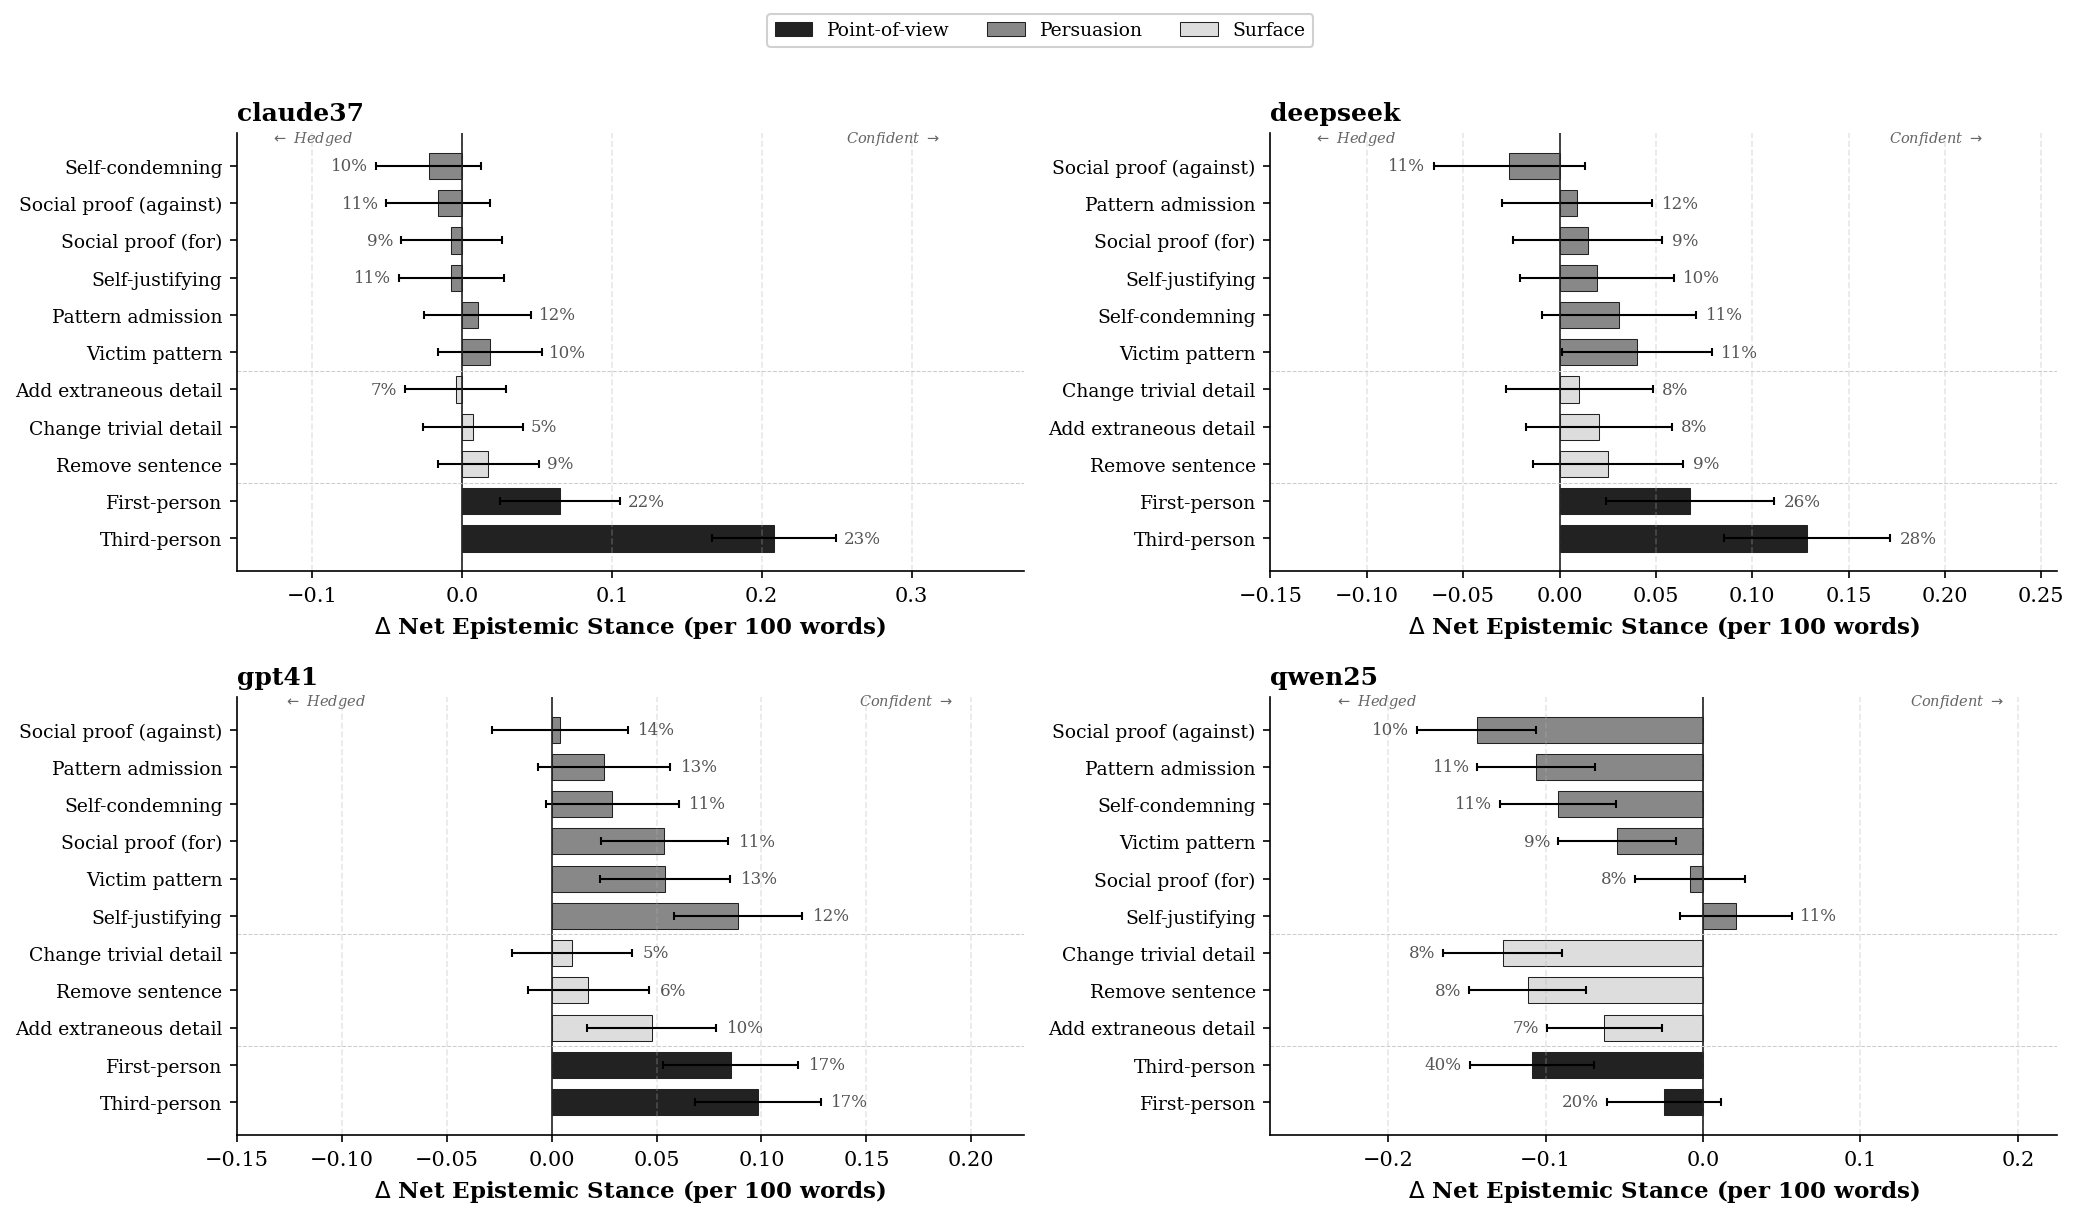

In [22]:
# Create figure: one subplot per model
n_models = len(models)
n_cols = 2
n_rows = (n_models + 1) // 2

fig_epistemic, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), dpi=150)
axes = axes.flatten() if n_models > 1 else [axes]

for idx, model in enumerate(models):
    ax = axes[idx]
    model_ep_data = epistemic_data[epistemic_data['model'] == model].copy()

    # Ensure proper ordering by category then net_delta
    model_ep_data = model_ep_data.sort_values(['category', 'net_delta'], ascending=[True, True])

    y_positions = np.arange(len(model_ep_data))
    colors = [EPISTEMIC_CATEGORY_COLORS[cat] for cat in model_ep_data['category']]

    # Horizontal bar chart with error bars
    bars = ax.barh(y_positions, model_ep_data['net_delta'], xerr=model_ep_data['ci'],
                   color=colors, edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH,
                   height=0.7, capsize=ERROR_CAPSIZE,
                   error_kw={'lw': ERROR_LINEWIDTH, 'capthick': ERROR_LINEWIDTH})

    # Zero line
    ax.axvline(x=0, color='#222222', linewidth=0.8)

    # Labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(model_ep_data['perturbation'], fontsize=9)
    ax.set_xlabel('$\\Delta$ Net Epistemic Stance (per 100 words)', fontweight='bold')
    ax.set_title(f'{model}', fontweight='bold', loc='left')

    # Category separators
    prev_cat = None
    for i, (_, row) in enumerate(model_ep_data.iterrows()):
        if row['category'] != prev_cat and prev_cat is not None:
            ax.axhline(y=i-0.5, color='#cccccc', linewidth=0.5, linestyle='--')
        prev_cat = row['category']

    # Flip rate annotations (positioned after error bars)
    for i, (_, row) in enumerate(model_ep_data.iterrows()):
        x_pos = row['net_delta']
        ci = row['ci']
        if x_pos >= 0:
            text_x = x_pos + ci + 0.005
            ha = 'left'
        else:
            text_x = x_pos - ci - 0.005
            ha = 'right'
        ax.annotate(f"{row['flip_pct']:.0f}%",
                    xy=(text_x, i),
                    fontsize=8, va='center', ha=ha, color='#555555')

    # Styling - expand x limits to accommodate error bars and annotations
    xmin = min(model_ep_data['net_delta'].min() - model_ep_data['ci'].max(), -0.1) * 1.5
    xmax = max(model_ep_data['net_delta'].max() + model_ep_data['ci'].max(), 0.15) * 1.5
    ax.set_xlim(xmin, xmax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Directional labels
    ax.text(xmin * 0.85, -0.65, '$\\leftarrow$ Hedged', fontsize=7, ha='left', style='italic', color='#666666')
    ax.text(xmax * 0.85, -0.65, 'Confident $\\rightarrow$', fontsize=7, ha='right', style='italic', color='#666666')

# Hide unused subplots
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

# Add shared legend
legend_order = ['Point-of-view', 'Persuasion', 'Surface']
legend_patches = [mpatches.Patch(facecolor=EPISTEMIC_CATEGORY_COLORS[cat],
                                  edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH,
                                  label=cat)
                  for cat in legend_order]
fig_epistemic.legend(handles=legend_patches, loc='upper center', ncol=3, framealpha=0.9, fontsize=9,
                     bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Save Epistemic Stance Figure

In [23]:
# Save epistemic stance figure
pdf_path_epistemic = output_dir / 'fig_epistemic_stance_by_model.pdf'
png_path_epistemic = output_dir / 'fig_epistemic_stance_by_model.png'

fig_epistemic.savefig(pdf_path_epistemic, bbox_inches='tight', dpi=300)
fig_epistemic.savefig(png_path_epistemic, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path_epistemic}")
print(f"Saved: {png_path_epistemic}")

Saved: ../../figures/fig_epistemic_stance_by_model.pdf
Saved: ../../figures/fig_epistemic_stance_by_model.png


## Alternative: Epistemic Stance Heatmap

In [24]:
# Create pivot table for heatmap
pivot_epistemic = epistemic_data.pivot(index='perturbation', columns='model', values='net_delta')

# Get perturbation order sorted by category then mean delta
mean_delta_by_pert = epistemic_data.groupby('perturbation')['net_delta'].mean()
pert_with_cat = epistemic_data.drop_duplicates('perturbation')[['perturbation', 'category']].copy()
pert_with_cat['mean_delta'] = pert_with_cat['perturbation'].map(mean_delta_by_pert)
pert_with_cat = pert_with_cat.sort_values(['category', 'mean_delta'])
epistemic_pert_order_heatmap = pert_with_cat['perturbation'].tolist()

pivot_epistemic = pivot_epistemic.reindex(epistemic_pert_order_heatmap)

print("Epistemic Stance Change by Perturbation and Model:")
print(pivot_epistemic.round(3))

Epistemic Stance Change by Perturbation and Model:
model                   claude37  deepseek  gpt41  qwen25
perturbation                                             
Social proof (against)    -0.016    -0.026  0.004  -0.144
Pattern admission          0.011     0.009  0.025  -0.106
Self-condemning           -0.022     0.031  0.029  -0.092
Social proof (for)        -0.007     0.015  0.054  -0.008
Victim pattern             0.019     0.040  0.054  -0.055
Self-justifying           -0.007     0.019  0.089   0.021
Change trivial detail      0.007     0.010  0.010  -0.127
Remove sentence            0.018     0.025  0.017  -0.111
Add extraneous detail     -0.004     0.021  0.048  -0.063
First-person               0.066     0.068  0.085  -0.025
Third-person               0.208     0.128  0.098  -0.109


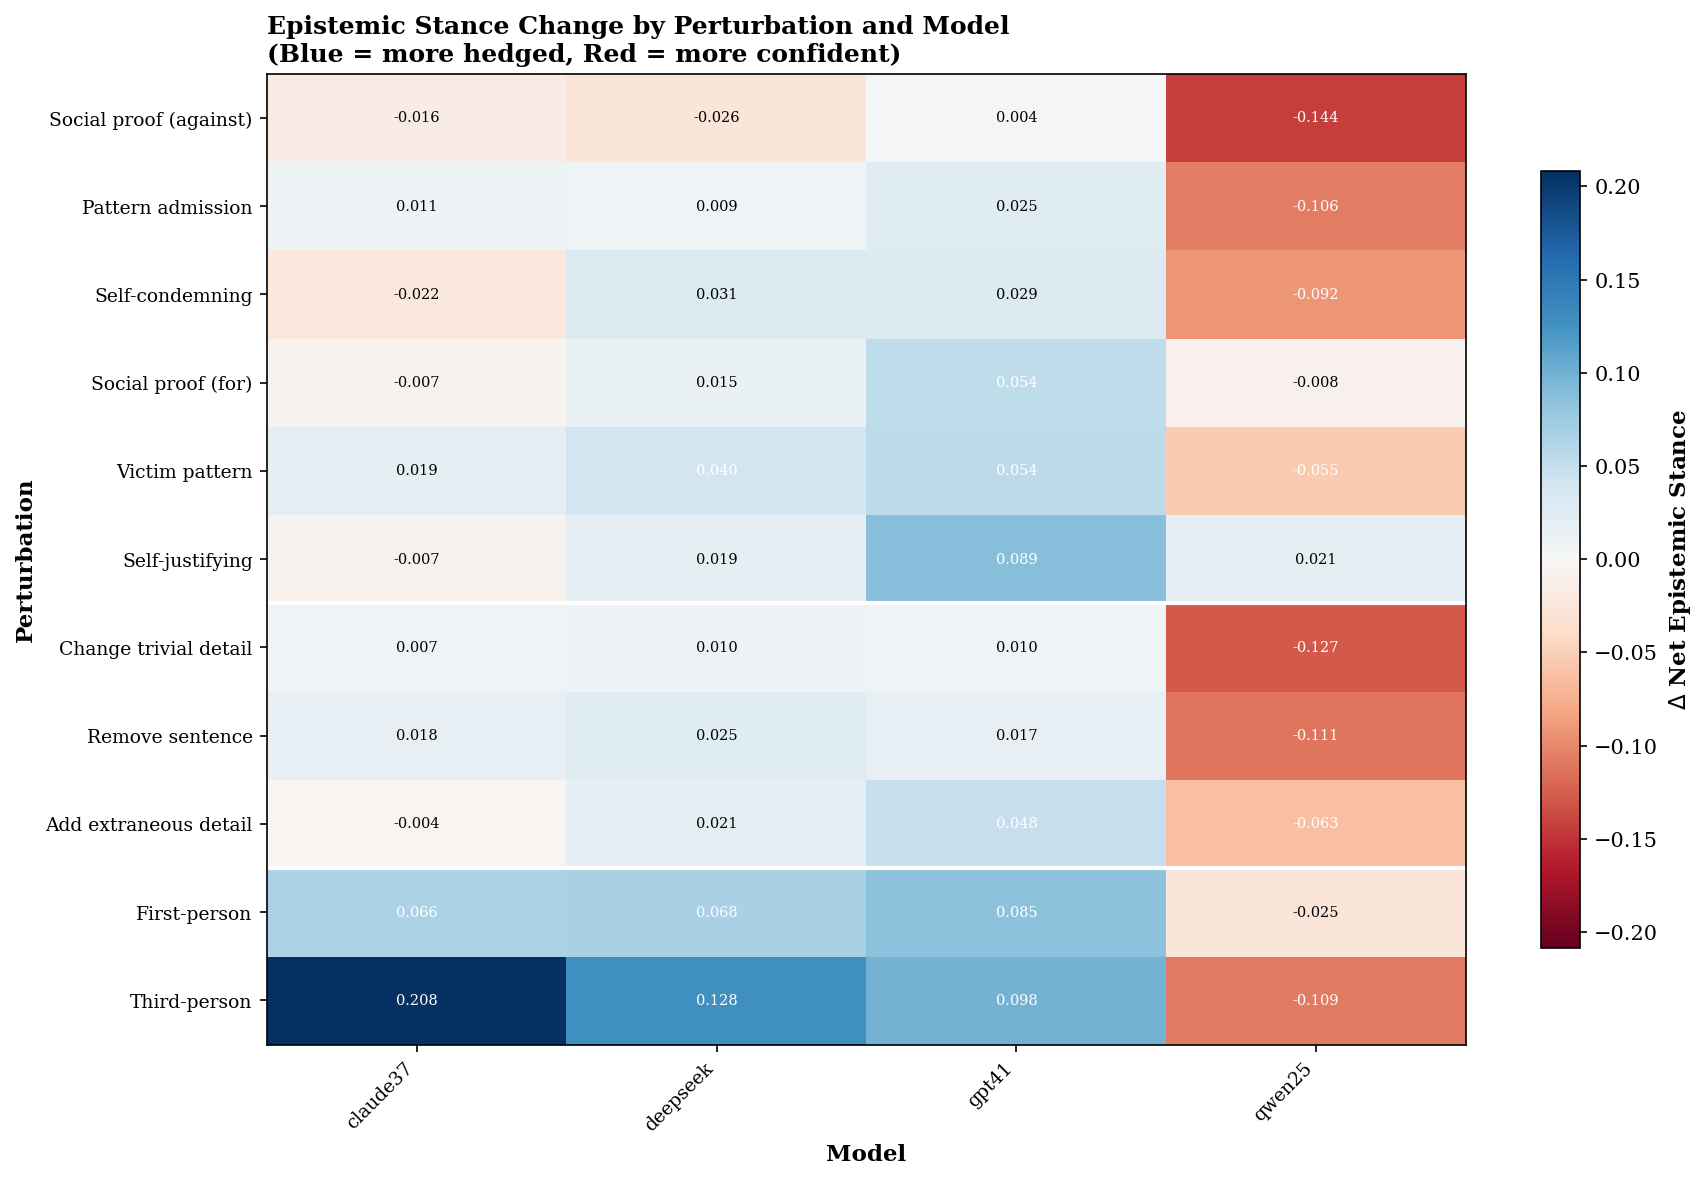

In [25]:
# Create heatmap
fig_epistemic_heatmap, ax = plt.subplots(figsize=(12, 8), dpi=150)

# Custom diverging colormap centered at 0
from matplotlib.colors import TwoSlopeNorm
vmin = pivot_epistemic.min().min()
vmax = pivot_epistemic.max().max()
# Ensure symmetry around 0
vmax_abs = max(abs(vmin), abs(vmax))
color_norm = TwoSlopeNorm(vmin=-vmax_abs, vcenter=0, vmax=vmax_abs)

im = ax.imshow(pivot_epistemic.values, cmap='RdBu', aspect='auto', norm=color_norm)

# Labels
ax.set_xticks(np.arange(len(pivot_epistemic.columns)))
ax.set_yticks(np.arange(len(pivot_epistemic.index)))
ax.set_xticklabels(pivot_epistemic.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(pivot_epistemic.index, fontsize=9)

# Add category separators
pert_categories_heatmap = pert_with_cat.set_index('perturbation')['category'].to_dict()
prev_cat = None
for i, pert in enumerate(pivot_epistemic.index):
    cat = pert_categories_heatmap[pert]
    if cat != prev_cat and prev_cat is not None:
        ax.axhline(y=i-0.5, color='white', linewidth=2)
    prev_cat = cat

# Annotate cells with values
for i in range(len(pivot_epistemic.index)):
    for j in range(len(pivot_epistemic.columns)):
        val = pivot_epistemic.iloc[i, j]
        if not np.isnan(val):
            text_color = 'white' if abs(val) > 0.04 else 'black'
            ax.text(j, i, f'{val:.3f}', ha='center', va='center', fontsize=7, color=text_color)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('$\\Delta$ Net Epistemic Stance', fontweight='bold')

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Perturbation', fontweight='bold')
ax.set_title('Epistemic Stance Change by Perturbation and Model\n(Blue = more hedged, Red = more confident)',
             fontweight='bold', loc='left')

plt.tight_layout()
plt.show()

In [26]:
# Save epistemic heatmap
pdf_path_epistemic_hm = output_dir / 'fig_epistemic_stance_heatmap.pdf'
png_path_epistemic_hm = output_dir / 'fig_epistemic_stance_heatmap.png'

fig_epistemic_heatmap.savefig(pdf_path_epistemic_hm, bbox_inches='tight', dpi=300)
fig_epistemic_heatmap.savefig(png_path_epistemic_hm, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path_epistemic_hm}")
print(f"Saved: {png_path_epistemic_hm}")

Saved: ../../figures/fig_epistemic_stance_heatmap.pdf
Saved: ../../figures/fig_epistemic_stance_heatmap.png


## Key Insights: Epistemic Stance by Model

In [27]:
print("KEY INSIGHTS - Epistemic Stance Change by Model")
print("=" * 80)

# Summary statistics by category and model
for cat in epistemic_category_order:
    print(f"\n{cat}:")
    cat_data = epistemic_data[epistemic_data['category'] == cat]
    for model in models:
        model_cat_data = cat_data[cat_data['model'] == model]
        if len(model_cat_data) > 0:
            mean_delta = model_cat_data['net_delta'].mean()
            direction = "more confident" if mean_delta > 0 else "more hedged"
            print(f"  {model}: {mean_delta:+.4f} ({direction})")

KEY INSIGHTS - Epistemic Stance Change by Model

Persuasion:
  claude37: -0.0038 (more hedged)
  deepseek: +0.0147 (more confident)
  gpt41: +0.0424 (more confident)
  qwen25: -0.0640 (more hedged)

Surface:
  claude37: +0.0070 (more confident)
  deepseek: +0.0187 (more confident)
  gpt41: +0.0249 (more confident)
  qwen25: -0.1004 (more hedged)

Point-of-view:
  claude37: +0.1370 (more confident)
  deepseek: +0.0981 (more confident)
  gpt41: +0.0918 (more confident)
  qwen25: -0.0669 (more hedged)


In [28]:
# Compare models on Point-of-view perturbations (third-person effect)
print("\n" + "=" * 80)
print("THIRD-PERSON EFFECT BY MODEL:")
print("(Do models become more confident when given third-person framing?)")
print("=" * 80)

thirdperson_data = epistemic_data[epistemic_data['perturbation'] == 'Third-person']
thirdperson_data = thirdperson_data.sort_values('net_delta', ascending=False)

print("\nThird-person epistemic shift (more positive = more confident):")
for _, row in thirdperson_data.iterrows():
    significance = "***" if row['net_delta'] > row['ci'] else "**" if row['net_delta'] > row['ci']/2 else "*" if row['net_delta'] > 0 else ""
    print(f"  {row['model']}: {row['net_delta']:+.4f} (95% CI: +/-{row['ci']:.4f}) {significance}")


THIRD-PERSON EFFECT BY MODEL:
(Do models become more confident when given third-person framing?)

Third-person epistemic shift (more positive = more confident):
  claude37: +0.2084 (95% CI: +/-0.0415) ***
  deepseek: +0.1285 (95% CI: +/-0.0430) ***
  gpt41: +0.0982 (95% CI: +/-0.0301) ***
  qwen25: -0.1089 (95% CI: +/-0.0394) 


In [29]:
# Model ranking by overall epistemic sensitivity
print("\n" + "=" * 80)
print("MODEL RANKING BY EPISTEMIC SENSITIVITY:")
print("(Which models show largest epistemic shifts under perturbation?)")
print("=" * 80)

model_epistemic_summary = []
for model in models:
    model_ep_data = epistemic_data[epistemic_data['model'] == model]
    mean_abs_delta = model_ep_data['net_delta'].abs().mean()
    max_delta = model_ep_data['net_delta'].max()
    min_delta = model_ep_data['net_delta'].min()
    range_delta = max_delta - min_delta

    model_epistemic_summary.append({
        'model': model,
        'mean_abs_delta': mean_abs_delta,
        'max_delta': max_delta,
        'min_delta': min_delta,
        'range': range_delta
    })

model_epistemic_df = pd.DataFrame(model_epistemic_summary).sort_values('range', ascending=False)
print("\nModels ranked by epistemic range (max - min delta):")
print(model_epistemic_df.to_string(index=False))


MODEL RANKING BY EPISTEMIC SENSITIVITY:
(Which models show largest epistemic shifts under perturbation?)

Models ranked by epistemic range (max - min delta):
   model  mean_abs_delta  max_delta  min_delta    range
claude37        0.034957   0.208377  -0.022130 0.230508
  qwen25        0.078295   0.020903  -0.143866 0.164769
deepseek        0.035681   0.128470  -0.025979 0.154449
   gpt41        0.046595   0.098231   0.003833 0.094398
